<a href="https://colab.research.google.com/github/DeepankarAcharyya/transfer_learning_demo/blob/main/Dogs_vs_Cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## For this demonstration, we will use data from the Dogs vs Cats dataset, available in kaggle.

### Downloading the dataset from Kaggle

URL : https://www.kaggle.com/c/dogs-vs-cats

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"

In [ ]:
%cd /content/drive/MyDrive/Projects-Misc/Transfer-Learning-Demo

/content/drive/MyDrive/Projects-Misc/Transfer-Learning-Demo


In [ ]:
!kaggle competitions download -c dogs-vs-cats

 98% 266M/271M [00:03<00:00, 99.7MB/s]
100% 271M/271M [00:03<00:00, 76.9MB/s]
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 12.2MB/s]
 99% 540M/543M [00:06<00:00, 73.4MB/s]
100% 543M/543M [00:06<00:00, 87.8MB/s]


### Extracting/ unzipping the downloaded zipped files

In [ ]:
!unzip test1.zip
!unzip train.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/dog.5499.jpg      
  inflating: train/dog.55.jpg        
  inflating: train/dog.550.jpg       
  inflating: train/dog.5500.jpg      
  inflating: train/dog.5501.jpg      
  inflating: train/dog.5502.jpg      
  inflating: train/dog.5503.jpg      
  inflating: train/dog.5504.jpg      
  inflating: train/dog.5505.jpg      
  inflating: train/dog.5506.jpg      
  inflating: train/dog.5507.jpg      
  inflating: train/dog.5508.jpg      
  inflating: train/dog.5509.jpg      
  inflating: train/dog.551.jpg       
  inflating: train/dog.5510.jpg      
  inflating: train/dog.5511.jpg      
  inflating: train/dog.5512.jpg      
  inflating: train/dog.5513.jpg      
  inflating: train/dog.5514.jpg      
  inflating: train/dog.5515.jpg      
  inflating: train/dog.5516.jpg      
  inflating: train/dog.5517.jpg      
  inflating: train/dog.5518.jpg      
  inflating: train/dog.5519.jpg      
  inflating: train/dog.552.jpg       

## Data Exploration:

In [7]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

In [8]:
base_dir = "/content/drive/MyDrive/Transfer-Learning-Demo"
train_dir = os.path.join(base_dir,'train')
test_dir = os.path.join(base_dir, 'test1')

In [9]:
train_images = os.listdir(train_dir)
test_images = os.listdir(test_dir)

print('Number of training images :', len(train_images))
print('Number of testing images :',len(test_images))

Number of training images : 25000
Number of testing images : 12500


### NOTE :
> Out of all the available training images, we will only use a set of randomly 998 (499 dogs and 499 cats) selected images for training purpose.

> For testing our final model, we will use images from the testing set.

### Visualizing the images

Image Shape: (499, 368, 3)


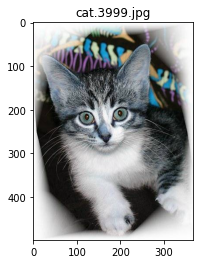

In [10]:
image = cv2.imread(os.path.join(train_dir,train_images[2]))
plt.title(train_images[2])
plt.imshow(image)

print("Image Shape:",image.shape)

### Defining a function for creating the target data from the image names :

In [11]:
def create_target(data_set):
  # 0=> cats && 1=> dogs
  y=[]
  for eachimage in data_set:
    if 'cat' in eachimage:
      y.append(0)
    elif 'dog' in eachimage:
      y.append(1)
    else:
      y.append(-1)
  return y

#### Testing out out function :

In [12]:
np.random.shuffle(train_images)
y1 = create_target(train_images[:5])
print('Length of the target:', len(y1))
for i in zip(train_images[:5],y1):
  print(i)

Length of the target: 5
('dog.7255.jpg', 1)
('cat.816.jpg', 0)
('cat.2178.jpg', 0)
('dog.10595.jpg', 1)
('cat.10141.jpg', 0)


### Function to separate out dogs and cats images into separate lists:

In [13]:
def separate_category(data_set):
  # 0=> cats && 1=> dogs
  dogs=[]
  cats=[]
  for eachimage in data_set:
    if 'cat' in eachimage:
      cats.append(eachimage)
    elif 'dog' in eachimage:
      dogs.append(eachimage)
    
  return dogs, cats

In [14]:
dog_images, cat_images = separate_category(train_images)
print('Number of dog images: ',len(dog_images))
print('Number of cat images: ',len(cat_images))

Number of dog images:  12500
Number of cat images:  12500


## Downloading the pre-trained model and setting it up :



---



## For our classification task, we will be using the keras' pre-trained xception model with weights trained on the imagenet dataset.

In [15]:
from keras import models
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array, load_img
from keras.layers import Dense,Flatten

from keras.applications.xception import Xception, preprocess_input

In [29]:
base_model = Xception(include_top=False,weights='imagenet',input_shape=(299,299,3))
base_model.trainable = False

model = models.Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(16, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 204800)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                3276816   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 24,138,313
Trainable params: 3,276,833
Non-trainable params: 20,861,480
_________________________________________________________________


In [30]:
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.01),metrics=['acc'])

### Creating the training data :

In [31]:
#shuffling the dog images
np.random.shuffle(dog_images)
#select the first 499 images
dogs_final = dog_images[:499]

In [32]:
#shuffling the cat images
np.random.shuffle(cat_images)
#select the first 499 images
cats_final = cat_images[:499]

In [33]:
#merge the two to form a final set of data
final_set = dogs_final + cats_final
#shuffle the final dataset
np.random.shuffle(final_set)
#check the length of the final_dataset
print('length of the final data set : ', len(final_set))
#create the target data
y = np.array(create_target(final_set))
#check the length of the target_set
print('length of the target set : ', y.shape)

length of the final data set :  998
length of the target set :  (998,)


### Function to read in the image :

In [34]:
def read_image(file_path):
  image = load_img(file_path, target_size=(299,299))
  image = img_to_array(image)
  #image = np.expand_dims(image,axis=0)
  image = preprocess_input(image)

  return image

In [35]:
def create_input(base_directory, images):
  x=[]
  for i in images:
    input_image = read_image(os.path.join(base_directory,i))
    x.append(input_image)
  
  return x

In [23]:
X = create_input(train_dir, final_set)
X = np.array(X)
X.shape

(998, 299, 299, 3)

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15)

## Final configurations and training the model :

In [38]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_path = os.path.join(base_dir,'xception_modified.h5')
checkpoint = ModelCheckpoint(checkpoint_path, monitor='acc', verbose=1, save_best_only=True, save_weights_only=True, mode='max')
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=4, verbose=1, mode='max')

In [ ]:
history = model.fit(X_train,y_train,epochs=10, validation_data=(X_val,y_val), callbacks=[checkpoint, early])

Epoch 1/10
27/27 [==============================] - 266s 10s/step - loss: 0.7726 - acc: 0.5142 - val_loss: 0.6931 - val_acc: 0.5067

Epoch 00001: acc improved from -inf to 0.51415, saving model to /content/drive/MyDrive/Transfer-Learning-Demo/xception_modified.h5
Epoch 2/10
27/27 [==============================] - 255s 9s/step - loss: 0.6856 - acc: 0.5071 - val_loss: 0.6885 - val_acc: 0.5133

Epoch 00002: acc did not improve from 0.51415
Epoch 3/10
27/27 [==============================] - 252s 9s/step - loss: 0.7169 - acc: 0.5071 - val_loss: 0.6931 - val_acc: 0.5067

Epoch 00003: acc did not improve from 0.51415
Epoch 4/10
27/27 [==============================] - 251s 9s/step - loss: 0.6908 - acc: 0.4717 - val_loss: 0.6931 - val_acc: 0.4933

Epoch 00004: acc did not improve from 0.51415
Epoch 5/10
25/27 [==========================>...] - ETA: 15s - loss: 0.6899 - acc: 0.5075

## Prediction :